## 1. The tweets
<p>I don’t usually post about politics (I’m not particularly savvy about polling, which is where data science has had the <a href="http://fivethirtyeight.com/">most substantial impact on politics</a>), but I saw a hypothesis about Donald Trump’s Twitter account that simply begged to be investigated with data: </p>
<p><a href="https://twitter.com/tvaziri/status/762005541388378112"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_511/img/tweet.png" alt="@tvaziri's hypothesis about Donald Trump’s Twitter account"></a></p>
<p>When Trump wishes the Olympic team good luck, he’s tweeting from his iPhone. When he’s insulting a rival, he’s usually tweeting from an Android. Is this an artifact showing which tweets are Trump’s own and which are by some handler in the campaign?</p>
<p>Others have <a href="http://www.cnet.com/news/trumps-tweets-android-for-nasty-iphone-for-nice/">explored Trump’s timeline</a> and noticed this tends to hold up. And Trump himself <a href="http://www.theverge.com/2015/10/5/9453935/donald-trump-twitter-strategy">did indeed tweet from a Samsung Galaxy</a> until <a href="https://www.recode.net/2017/5/27/15705090/president-donald-trump-twitter-android-iphone-ios-samsung-galaxy-security-hacking">March 2017</a>. But how could we examine it quantitatively? During the development of the <a href="http://github.com/juliasilge/tidytext">tidytext R package</a>, I was writing about writing about text mining and sentiment analysis, and this is an excellent opportunity to apply it again.</p>
<p>My analysis, shown below, concludes that <strong>the Android and iPhone tweets are clearly from different people</strong>. Tweets from these two devices are posted during different times of day, and the use of hashtags, links, and retweets are distinctive. What’s more, we can see that <strong>the Android tweets are angrier and more negative</strong>, while the iPhone tweets tend to be benign announcements and pictures. Overall I’d agree with <a href="https://twitter.com/tvaziri/">@tvaziri</a>’s analysis. We can tell the difference between the campaign’s tweets (iPhone) and Trump’s own (Android). Let's see how.</p>
<p>First, let's load the content of Donald Trump’s timeline. Our dataset is from <a href="http://www.trumptwitterarchive.com/">The Trump Twitter Archive</a> by Brendan Brown, which contains all 35,000+ tweets from the <a href="https://twitter.com/realDonaldTrump/">@realDonaldTrump</a> Twitter account from 2009 (the year Trump sent his <a href="https://www.businessinsider.de/donald-trump-first-tweet-2017-5">first tweet</a>) through 2018. We'll filter it for the election period only, June 1st, 2015 through November 8th, 2016.</p>

In [23]:
# Load the libraries
library(tidyverse)
library(lubridate)

# Read in the data
tweets <- read_csv('datasets/trump_tweets.csv', guess_max = 36000) %>%
  filter(created_at > '2015-06-01' , created_at < '2016-11-08' )

# Inspect the first six rows
head(tweets)

Parsed with column specification:
cols(
  source = col_character(),
  id_str = col_double(),
  text = col_character(),
  created_at = col_datetime(format = ""),
  retweet_count = col_integer(),
  in_reply_to_user_id_str = col_double(),
  favorite_count = col_integer(),
  is_retweet = col_logical()
)


source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
Twitter for Android,6.827032e+17,"I would like to wish everyone A HAPPY AND HEALTHY NEW YEAR. WE MUST ALL WORK TOGETHER TO, FINALLY, MAKE AMERICA SAFE AGAIN AND GREAT AGAIN!",2015-12-31 23:21:49,6776,NA,16495,FALSE
Twitter for Android,6.827007e+17,"Do you believe that The State Department, on NEW YEAR'S EVE, just released more of Hillary's e-mails. They just want it all to end. BAD!",2015-12-31 23:11:35,2755,NA,6824,FALSE
Twitter for iPhone,6.826351e+17,THANK YOU ILLINOIS! Let's not forget to get family &amp; friends- out to VOTE IN 2016! https://t.co/lg5kMbNLYK https://t.co/dtMAsIq4cf,2015-12-31 18:51:12,2468,NA,6047,FALSE
Twitter for iPhone,6.826053e+17,"HAPPY BIRTHDAY to my son, @DonaldJTrumpJr! Very proud of you! #TBT https://t.co/ULerCEOCGX https://t.co/nbxPVdarJM",2015-12-31 16:52:38,2080,NA,8416,FALSE
Twitter for Android,6.825788e+17,I would feel sorry for @JebBush and how badly he is doing with his campaign other than for the fact he took millions of $'s of hit ads on me,2015-12-31 15:07:18,1875,NA,5780,FALSE
Twitter for iPhone,6.825446e+17,#MakeAmericaGreatAgain #Trump2016 https://t.co/IEIXos0wh9,2015-12-31 12:51:35,2285,NA,5729,FALSE


## 2. Clean those tweets
<p>We'll clean the data by extracting the source application. We’re only looking at the iPhone and Android tweets. A much smaller number of tweets are from the web client or iPad.</p>
<p>Overall, the cleaned data should include 2275 tweets from an iPhone device and 4240 tweets from an Android device.</p>

In [25]:
# Count the nubmer of tweets by source
tweets %>% count(source)

# Clean the tweets
cleaned_tweets <- tweets %>%
    select(id_str, source, text, created_at) %>% 
    filter(source %in% c("Twitter for Android", "Twitter for iPhone")) %>%
    extract(source, "source", "(\\w+)$")

# Inspect the first six rows
head(cleaned_tweets)

source,n
Facebook,2
Instagram,47
Media Studio,1
Mobile Web (M5),1
Periscope,7
TweetDeck,2
Twitter Ads,63
Twitter Mirror for iPad,1
Twitter QandA,10
Twitter Web Client,1301


id_str,source,text,created_at
6.827032e+17,Android,"I would like to wish everyone A HAPPY AND HEALTHY NEW YEAR. WE MUST ALL WORK TOGETHER TO, FINALLY, MAKE AMERICA SAFE AGAIN AND GREAT AGAIN!",2015-12-31 23:21:49
6.827007e+17,Android,"Do you believe that The State Department, on NEW YEAR'S EVE, just released more of Hillary's e-mails. They just want it all to end. BAD!",2015-12-31 23:11:35
6.826351e+17,iPhone,THANK YOU ILLINOIS! Let's not forget to get family &amp; friends- out to VOTE IN 2016! https://t.co/lg5kMbNLYK https://t.co/dtMAsIq4cf,2015-12-31 18:51:12
6.826053e+17,iPhone,"HAPPY BIRTHDAY to my son, @DonaldJTrumpJr! Very proud of you! #TBT https://t.co/ULerCEOCGX https://t.co/nbxPVdarJM",2015-12-31 16:52:38
6.825788e+17,Android,I would feel sorry for @JebBush and how badly he is doing with his campaign other than for the fact he took millions of $'s of hit ads on me,2015-12-31 15:07:18
6.825446e+17,iPhone,#MakeAmericaGreatAgain #Trump2016 https://t.co/IEIXos0wh9,2015-12-31 12:51:35


## 3. Is "time" the giveaway?
<p>Most people are creatures of habit, and we would expect their tweet times to be a type of ‘signature’. We can certainly spot the difference here. Most tweets from the Android are in the early morning or later in the evening, while tweets from the iPhone occur more often in the afternoon.</p>

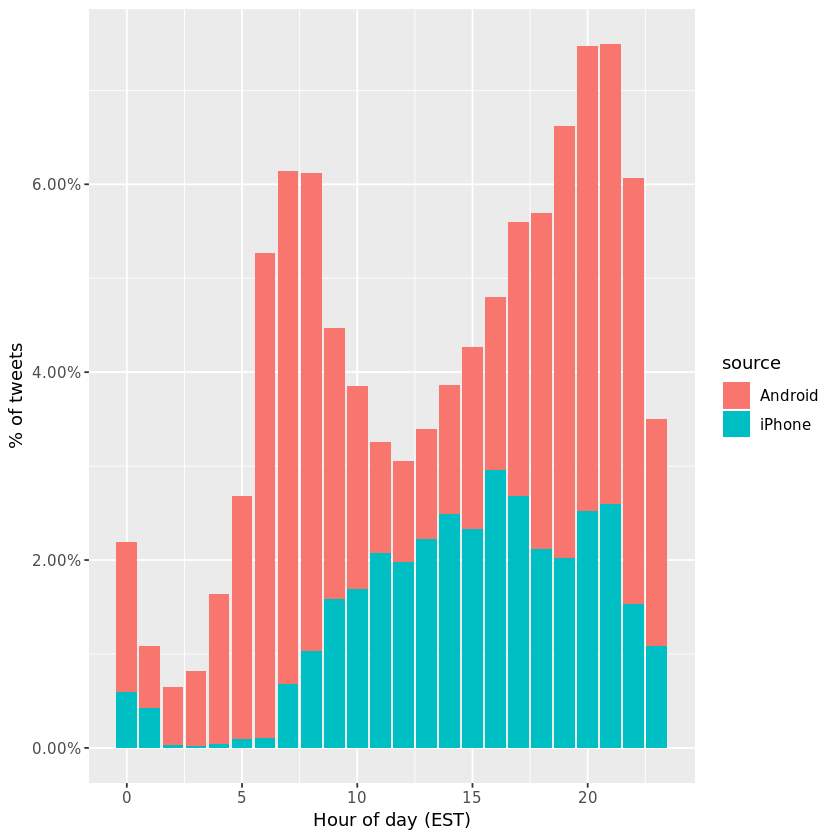

In [27]:
# Load the scales package
library(scales)

#  Plot the percentage of tweets by hour of the day for each device
cleaned_tweets %>%
  count(source, hour = hour(with_tz(created_at, "EST"))) %>%
  mutate(percent = n / sum(n)) %>% 
  ggplot(aes(x = hour, percent, fill = source)) +
  geom_col() +
  scale_y_continuous(labels = percent_format()) +
  labs(x = 'Hour of day (EST)', y = '% of tweets', color = "")

## 4. The quote tweet is dead
<p>Another place we can spot a difference is in Trump’s anachronistic behavior of “manually retweeting” people by copy-pasting their tweets, then surrounding them with quotation marks. These are known as <a href="https://www.theringer.com/tech/2018/5/2/17311616/twitter-retweet-quote-endorsement-function-trolls">quote tweets</a>.</p>
<p><a href="https://twitter.com/realDonaldTrump/status/758512401629192192"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_511/img/tweet_quotes.png" alt="Trump quote-tweeting someone"></a></p>
<p>Almost all the quote tweets are posted from the Android.</p>
<p>After this plot, we’ll filter out the quote tweets in the remaining <strong>by-word</strong> analyses because they contain text from followers that may not be representative of Trump’s tweets.</p>

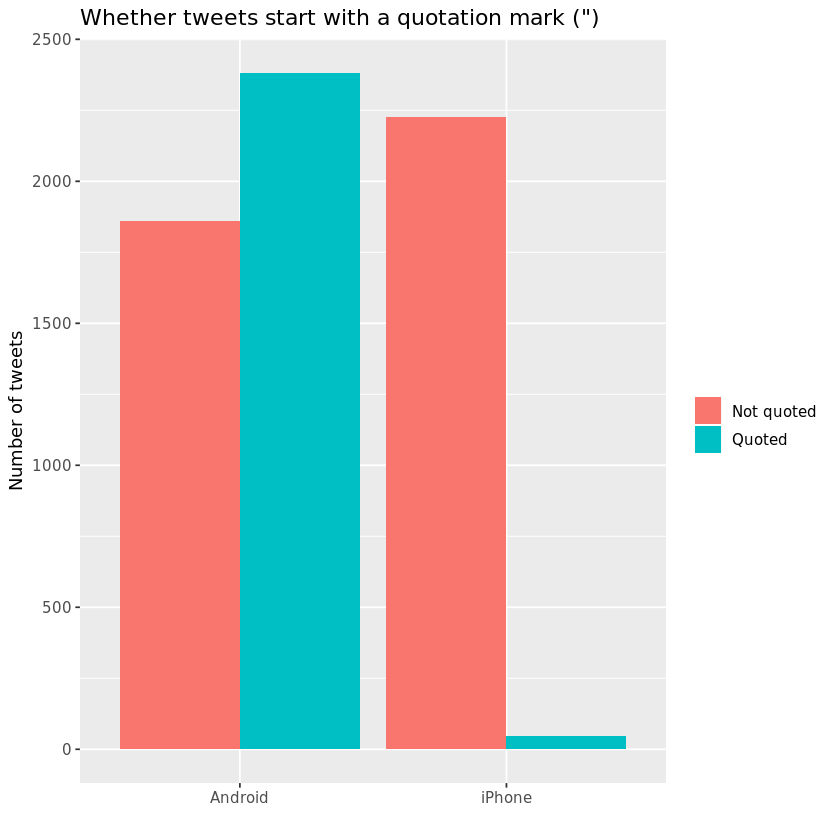

In [29]:
#  Plot the number of tweets with and without quotes by device
cleaned_tweets %>%
  count(source,
        quoted = ifelse(str_detect(text, '^"'), "Quoted", "Not quoted")) %>%
  ggplot(aes(x = source, y = n, fill = quoted)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "", y = "Number of tweets", fill = "") +
  ggtitle('Whether tweets start with a quotation mark (")')

## 5. Links and pictures
<p>Another place we see a difference between the iPhone and Android tweets is in the sharing of links or pictures.</p>
<p>It turns out that tweets from the iPhone were <strong>way more likely to contain either a picture or a link</strong>. This also makes sense with our narrative: iPhone (presumably run by the campaign) tends to write “announcement” tweets about events, like this:</p>
<p><a href="https://twitter.com/realDonaldTrump/status/762110918721310721"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_511/img/tweet_windham.png" alt="&quot;Thank you Windham, New Hampshire!&quot;"></a></p>
<p>While Android (Trump himself) tends to write picture-less tweets like:</p>
<p><a href="https://twitter.com/realDonaldTrump/status/762400869858115588"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_511/img/tweet_media.png" alt="&quot;The media is going crazy...very dishonest!&quot;"></a></p>

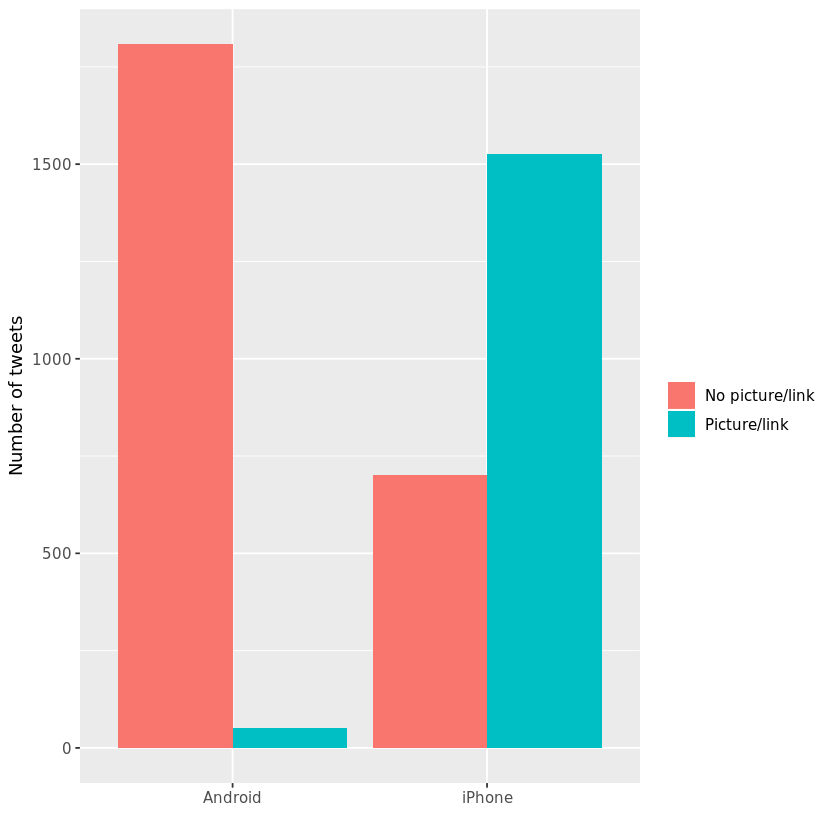

In [31]:
#  Count the number of tweets with and without picture/links by device
tweet_picture_counts <- cleaned_tweets %>%
  filter(!str_detect(text, '^"')) %>%
  count(source,
        picture = ifelse(str_detect(text, "t.co"),
                         "Picture/link", "No picture/link"))

# Make a bar plot 
ggplot(tweet_picture_counts, aes(x = source, y = n, fill = picture)) +
  geom_bar(stat = "identity", position = 'dodge') +
  labs(x = "", y = "Number of tweets", fill = "")

## 6. Comparison of words
<p>Now that we’re sure there is a difference between these two platforms, what can we say about the difference in the <em>content</em> of the tweets? We’ll use the <a href="https://cran.r-project.org/web/packages/tidytext">tidytext package</a> that <a href="http://juliasilge.com/">Julia Silge</a> and I developed.</p>
<p>We start by dividing lines of text into individual words using <code>unnest_tokens()</code> (see <a href="https://cran.r-project.org/web/packages/tidytext/vignettes/tidytext.html">this vignette</a> for more), and by removing some common “stopwords”.</p>

In [33]:
# Load the tidytext package
library(tidytext)

# Create a regex pattern
reg <- "([^A-Za-z\\d#@']|'(?![A-Za-z\\d#@]))"

# Unnest the text strings into a data frame of words
tweet_words <- cleaned_tweets %>%
  filter(!str_detect(text, '^"')) %>%
  mutate(text = str_replace_all(text, "https://t.co/[A-Za-z\\d]+|&amp;", "")) %>%
  unnest_tokens(word, text, token = "regex", pattern = reg) %>%
  filter(!word %in% stop_words$word,
         str_detect(word, "[a-z]"))

# Inspect the first six rows of tweet_words
head(tweet_words)

id_str,source,created_at,word
6.053187e+17,Android,2015-06-01 10:23:13,@foxandfriends
6.053187e+17,Android,2015-06-01 10:23:13,enjoy
6.066705e+17,Android,2015-06-05 03:55:04,worst
6.066705e+17,Android,2015-06-05 03:55:04,boring
6.066705e+17,Android,2015-06-05 03:55:04,political
6.066705e+17,Android,2015-06-05 03:55:04,pundits


## 7. Most common words
<p>What are the most common words @realDonaldTrump tweets? This plot should look familiar to anyone who has seen the feed.</p>

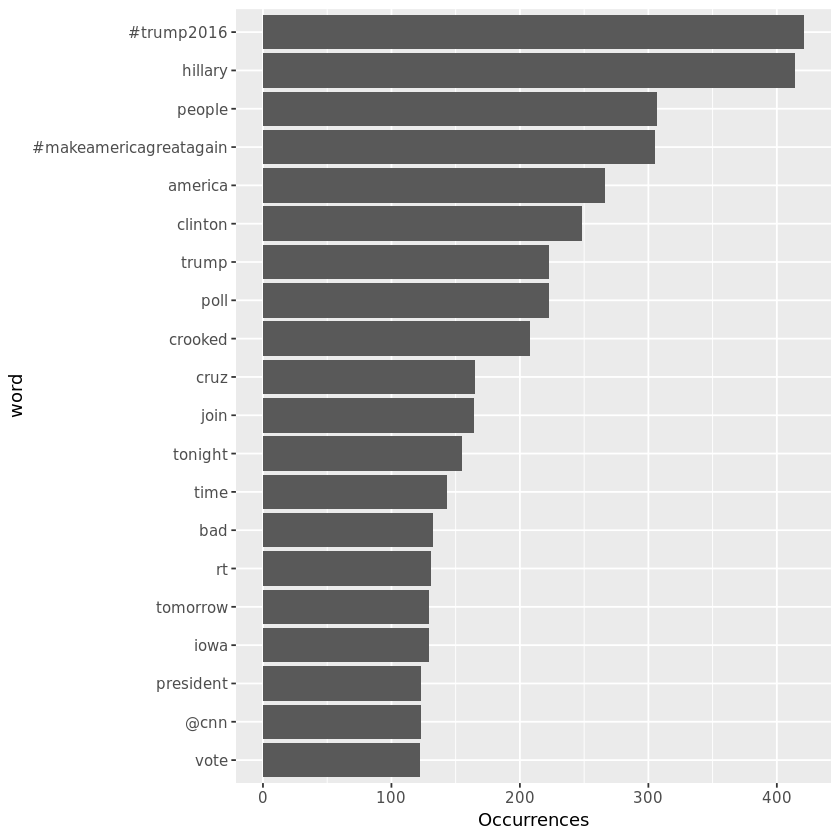

In [35]:
# Plot the most common words from @realDonaldTrump tweets
tweet_words %>%
  count(word, sort = TRUE) %>%
  head(n = 20) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(x = word, y = n)) +
  geom_bar(stat = "identity") +
  ylab("Occurrences") +
  coord_flip()

## 8. Common words: Android vs. iPhone (i)
<p>Now let’s consider which words are most common from the Android relative to the iPhone, and vice versa. We’ll use the simple measure of log odds ratio <strong>for each word</strong>, calculated as:</p>
<p>$$\log_2(\frac{\frac{\mbox{# in Android} + 1}{\mbox{Total #words Android} + 1}} {\frac{\mbox{# in iPhone} + 1}{\mbox{Total #words iPhone} + 1}})$$</p>
<p><br></p>
<p>We'll only be looking at words that occur at least five times in both platforms. There will be some instances with fewer than five uses in either the Android or the iPhone, but never one with fewer than five total. If there is one occurrence of a word in the Android, you'll know that there are at least four occurrences in the iPhone for the same word.</p>
<p><br></p>
<p>The “$ + 1$”, called <a href="https://en.wikipedia.org/wiki/Additive_smoothing">Laplace smoothing</a>, are to avoid dividing by zero and to put <a href="http://varianceexplained.org/r/empirical_bayes_baseball/">more trust in common words</a>.</p>

In [37]:
# Create the log odds ratio of each word
android_iphone_ratios <- tweet_words %>%
  count(word, source) %>%
  group_by(word)  %>% 
  filter(sum(n) >= 5) %>%
  spread(source, n, fill = 0) %>%
  ungroup() %>%
  mutate_if(is.numeric, funs((. + 1) / sum(. + 1))) %>%
  mutate(logratio = log2(Android / iPhone)) %>%
  arrange(desc(logratio))

# Inspect the first six rows
head(android_iphone_ratios)

word,Android,iPhone,logratio
mails,0.0016695703,7.984669e-05,4.386100
poor,0.0010162602,7.984669e-05,3.669893
poorly,0.0009436702,7.984669e-05,3.562978
bosses,0.0008710801,7.984669e-05,3.447501
turnberry,0.0008710801,7.984669e-05,3.447501
angry,0.0007984901,7.984669e-05,3.321970


## 9. Common words: Android vs. iPhone (ii)
<p>Now that we've calculated the log odds ratio of each word, we'll plot the 15 words with the greatest log odds ratio for the Android and the iPhone.</p>
<p>With the way we've set up the log odds ratio, positive values are assigned to words from the Android, and negative values are assigned to the iPhone. </p>

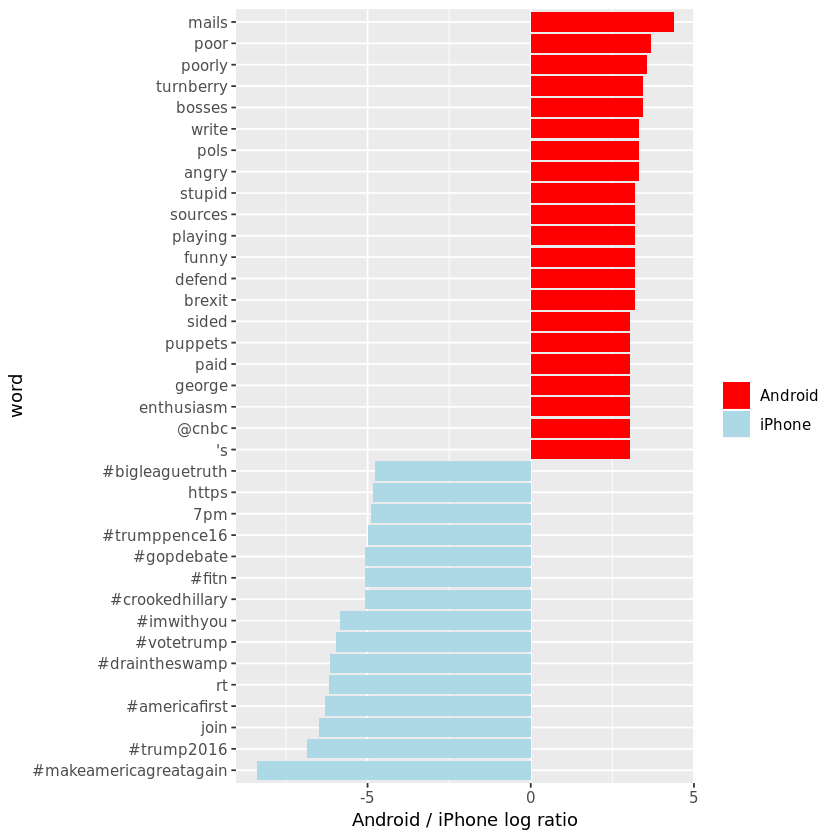

In [39]:
# Plot the log odds ratio for each word by device
android_iphone_ratios %>%
  group_by(logratio > 0) %>%
  top_n(n = 15, abs(logratio)) %>%
  ungroup() %>%
  mutate(word = reorder(word, logratio)) %>%
  ggplot(aes(x = word, y = logratio, fill = logratio < 0)) +
  geom_bar(stat = 'identity') +
  coord_flip() +
  ylab("Android / iPhone log ratio") +
  scale_fill_manual(name = "", labels = c("Android", "iPhone"),
                    values = c("red", "lightblue"))

## 10. Adding sentiments
<p>What do we know so far? </p>
<ul>
<li><p><strong>Most hashtags come from the iPhone.</strong> Indeed, almost no tweets from Trump's Android contained hashtags, with some rare exceptions like <a href="https://twitter.com/realDonaldTrump/status/753960134422900736">this one</a>. (This is true only because we filtered out the quoted "retweets," as Trump does sometimes quote tweets <a href="https://twitter.com/realDonaldTrump/status/731805331425218560">like this</a> that contain hashtags).</p></li>
<li><p><strong>Words like "join" and times like "7 pm", came only from the iPhone.</strong> The iPhone is responsible for event announcements like <a href="https://twitter.com/realDonaldTrump/status/743522630230228993">this one</a> ("Join me in Houston, Texas tomorrow night at 7 pm!")</p></li>
<li><p><strong>Emotionally charged words, like "poorly," "angry," and "stupid" were more common on Android.</strong> This supports the original hypothesis that this is the "angrier" or more hyperbolic account.</p></li>
</ul>
<p>Since we’ve observed a difference in word use between the Android and iPhone tweets, let's see if there's a difference in sentiment. We’ll work with the NRC Word-Emotion Association lexicon, available from the tidytext package, which associates words with ten sentiments: positive, negative, anger, anticipation, disgust, fear, joy, sadness, surprise, and trust.</p>

In [52]:
# Create a sentiment data frame from the NRC lexicon
nrc <- sentiments %>%
  filter(lexicon == "nrc") %>%
  select(word, sentiment)

# Join the NRC lexicon to the 
android_iphone_sentiment <- android_iphone_ratios %>%
  inner_join(nrc, by = "word") %>%
  filter(!sentiment %in% c("positive", "negative")) %>%
  mutate(sentiment = reorder(sentiment, -logratio),
         word = reorder(word, -logratio)) %>%
  group_by(sentiment) %>%
  top_n(10, abs(logratio)) %>%
  ungroup()

# Inspect the first six rows
head(android_iphone_sentiment)

word,Android,iPhone,logratio,sentiment
angry,0.0007984901,7.984669e-05,3.321970,anger
angry,0.0007984901,7.984669e-05,3.321970,disgust
defend,0.0007259001,7.984669e-05,3.184466,fear
enthusiasm,0.0006533101,7.984669e-05,3.032463,anticipation
enthusiasm,0.0006533101,7.984669e-05,3.032463,joy
enthusiasm,0.0006533101,7.984669e-05,3.032463,surprise


## 11. Android vs. iPhone sentiments
<p>Now we'll take a look at the sentiments of the common words from both devices. We'll see that a lot of words annotated as negative sentiments (with a few exceptions like “crime” and “terrorist”) are more common in Trump’s Android tweets than the campaign’s iPhone tweets.</p>

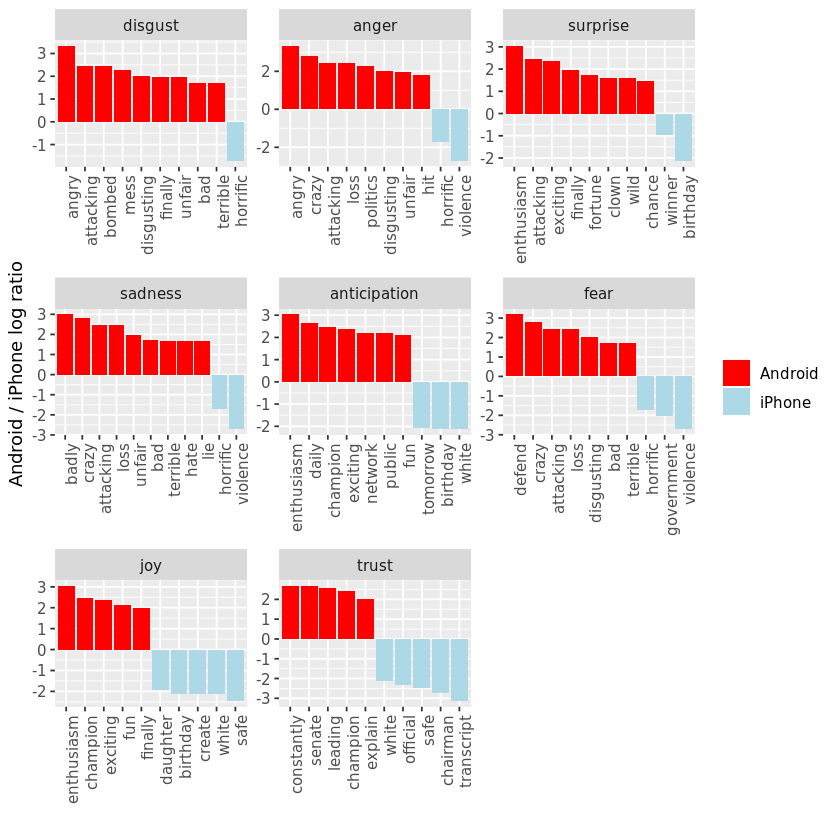

In [53]:
# Plot the log odds ratio of words by device in groups sentiments
ggplot(android_iphone_sentiment, aes(x = word, y = logratio, fill = logratio < 0)) +
  facet_wrap(~ sentiment, scales = "free", nrow = 3) +
  geom_bar(stat = "identity") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = "", y = "Android / iPhone log ratio") +
  scale_fill_manual(name = "", labels = c("Android", "iPhone"),
                    values = c("red", "lightblue"))

## 12. Conclusion: The ghost in the political machine
<p>There's a difference in style and sentiment between Trump's tweets from the Android and the iPhone. We know Trump used the Android until March 2017, but who was tweeting from the iPhone on Trump's behalf? I was fascinated by a <a href="http://www.newyorker.com/magazine/2016/07/25/donald-trumps-ghostwriter-tells-all">New Yorker article</a> about Tony Schwartz, Trump’s ghostwriter for <em>The Art of the Deal</em>. Of particular interest was how Schwartz imitated Trump’s voice and philosophy:</p>
<blockquote>
  <p><em>In his journal, Schwartz describes the process of trying to make Trump’s voice palatable in the book. It was kind of “a trick,” he writes, to mimic Trump’s blunt, staccato, no-apologies delivery while making him seem almost boyishly appealing…. Looking back at the text now, Schwartz says, “I created a character far more winning than Trump is.”</em></p>
</blockquote>
<p>A lot has been written about Trump’s mental state. But I’d rather get inside the head of the anonymous staffer whose job is to imitate Trump’s unique cadence (“Very sad!”) or put a positive spin on it, to millions of his followers. Are they a true believer, or just a cog in a political machine, mixing whatever mainstream appeal they can into the <a href="https://twitter.com/realDonaldTrump">@realDonaldTrump</a> concoction? Like Tony Schwartz, will they one day regret their involvement?</p>

In [ ]:
anonymous_iPhone_tweeter <- ....